In [ ]:
### SCRATCH NOTEBOOK TO GET DIFFUSION WORKING IN ISOLATION BEFORE APPLYING IT TO THE MAIN SIMULATION ###
### MAYBE UNNECESSARY TO ISOLATE IN THIS WAY, BUT MADE ME MORE COMFY ###

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import scipy as sp
import cProfile

In [2]:
### Global Constants ###
K = 1.38e-23         # Boltzmann constant (J/K)
T = 300             # temperature (K)
CHARGE = 1.6e-19    # electron charge (C)
BIAS = 180           # operational volatge (V)
PAIR_CREATION_E = 3.62e-3  # pair creation energy in Si (keV)
MU_E = 1350         #cm^2/Vs
MU_H = 480          #cm^2/Vs
xv_um = 1000         #um
xi_um = 75          #um

xi = xi_um * 1e-4   #cm
xg = 0              #cm          
xv = xv_um * 1e-4   #cm

In [3]:
#  In V
def get_potential(x, bias = BIAS):
    return bias * x / (xv - xg)


#  currently constant so no x dependence
#  returns V/cm
def get_electric_field(x, bias = BIAS):     
    return bias / (xv - xg)


#  returns cm/s (i think)
def get_drift_speed(x_pos, type):
    if type == 'electron':
        mu = MU_E
    elif type == 'hole':
        mu = MU_H
    return mu * get_electric_field(x_pos)


def instant_i(x_pos, type):
    return CHARGE + get_drift_speed(x_pos, type) * get_electric_field(x_pos, bias=1)  # Shockley-Ramo theorem


# not used **yet**
def calc_sigma(sampx, del_x, type):
    E_field = get_electric_field(sampx)
    sig_x = np.sqrt((2*K*T*del_x)/(CHARGE*E_field))         # standard deviation of spatial diffusion in cm -- units work I swear 
    speed = get_drift_speed(sampx, type)                    # stdev of collection time diffusion in s (i think)
    sig_t = sig_x / speed          
    return sig_t   


def gauss_blur(array, sigma, timestep):
    std_dev = sigma / timestep
    return sp.ndimage.gaussian_filter1d(array, std_dev)


#  generate array of [x position, corresponding instantaneous current, corresponding weighting potential] for an electron and hole in the detector
#  Looks like:   j=0   [[x0, i0, w0]
#                j=1    [x1, i1, w1]
#                           ...
#                j=n    [xn, in, wn]
#  where n is the number of small steps taken by the charge carrier, determined by the timestep * the drift speed
def generate_arrays(timestep, xv, xg):
    electron_array = []
    x_now = xg
    while x_now <= xv:
        i_e = instant_i(x_now, 'electron')
        w_pot = get_potential(x_now, bias = 1)
        electron_array.append([x_now, i_e, w_pot])
        x_now += get_drift_speed(x_now, 'electron') * timestep

    hole_array = []
    x_now = xv
    while x_now >= xg:
        i_h = instant_i(x_now, 'hole')
        w_pot = get_potential(x_now, bias = 1)
        hole_array.append([x_now, i_h, w_pot])
        x_now -= get_drift_speed(x_now, 'hole') * timestep

    return np.array(electron_array), np.array(hole_array)


def generate_current(timeline, timestep, x_init, electron_array, hole_array, type):
    if type == 'electron':
        x_index = np.searchsorted(electron_array[:,0], x_init)
        current = electron_array[x_index:,1]
    elif type == 'hole':
        hole_sort = np.argsort(hole_array[:,0])
        x_index = np.searchsorted(hole_array[:,0], x_init, sorter=hole_sort)
        current = hole_array[-(x_index+1):,1]
    
    length = current.size
    total_time = length * timestep
    time_len = timeline.size
    fill = np.full(time_len - length, 0)
    current = np.concatenate((current, fill),0)
    return current, total_time


# timestep not necessary here only to calc total time of current, also could be done with only passing one array, 
# or incorporated into a class where the arrays are attributes that don't need to be passed
def generate_current_w_diffusion(timeline, timestep, x_init, electron_array, hole_array, type, convolve=False):
    if type == 'electron':
        x_index = np.searchsorted(electron_array[:,0], x_init)
        current = electron_array[x_index:,1]
        del_x = xv - x_init
    elif type == 'hole':
        hole_sort = np.argsort(hole_array[:,0])
        x_index = np.searchsorted(hole_array[:,0], x_init, sorter=hole_sort)
        current = hole_array[-(x_index+1):,1]
        del_x = x_init - xg

    sig_t = calc_sigma(x_init, del_x, type)
    length = current.size
    total_time = (length-1) * timestep
    time_len = timeline.size

    if convolve:
        newlen = current.size
        fill = np.full(time_len - newlen, 0)
        current = np.concatenate((current, fill),0)
        current = gauss_blur(current, sig_t, timestep)
        return current, total_time
    
    else:
        last_t = np.random.normal(total_time, sig_t)
        last_index = last_t / timestep
        brute_extend_len = last_index - (length -1)
        brute_extend_len_int = int(round(brute_extend_len))

        if brute_extend_len > 0:
            brute_extend = np.full(brute_extend_len_int, current[-1], dtype='float')
            current = np.concatenate((current, brute_extend))
        elif brute_extend_len < 0:
            current = current[:brute_extend_len_int+1]

        newlen = current.size
        fill = np.full(time_len - newlen, 0)
        current = np.concatenate((current, fill),0)
        return current, total_time, brute_extend_len


def single_pair_sim(x_init, time, timestep, electron_array, hole_array, diff=False, convolve=False):
    if diff:
        if convolve: 
            current_v_timee, total_time_e = generate_current_w_diffusion(time, timestep, x_init, electron_array, hole_array, 'electron', convolve=convolve)
            current_v_timeh, total_time_h = generate_current_w_diffusion(time, timestep, x_init, electron_array, hole_array, 'hole', convolve=convolve)
        else:
            current_v_timee, total_time_e, brute_extend_len_e = generate_current_w_diffusion(time, timestep, x_init, electron_array, hole_array, 'electron')
            current_v_timeh, total_time_h, brute_extend_len_h = generate_current_w_diffusion(time, timestep, x_init, electron_array, hole_array, 'hole')
            #charge_v_timee, total_time_e2 = generate_charge(time, timestep, x_init, electron_array, hole_array, 'electron')     # integration would be better here womp womp
            #charge_v_timeh, total_time_h2 = generate_charge(time, timestep, x_init, electron_array, hole_array, 'hole')         # but I liked the slicing method :(
    else:
        current_v_timee, total_time_e = generate_current(time, timestep, x_init, electron_array, hole_array, 'electron')
        current_v_timeh, total_time_h = generate_current(time, timestep, x_init, electron_array, hole_array, 'hole')
        #charge_v_timee, total_time_e2 = generate_charge(time, timestep, x_init, electron_array, hole_array, 'electron')     # integration would be better here womp womp
        #charge_v_timeh, total_time_h2 = generate_charge(time, timestep, x_init, electron_array, hole_array, 'hole')         # but I liked the slicing method :(
    
    sum_current = current_v_timee + current_v_timeh
    #sum_charge = charge_v_timee + charge_v_timeh
    return sum_current#, sum_charge


def simulate_event(x_inits, time, timestep, electron_array, hole_array, diff=False, convolve=False):
    total_current = np.zeros(time.shape)
    total_charge = np.zeros(time.shape)
    for x_init in x_inits:
        sum_current = single_pair_sim(x_init, time, timestep, electron_array, hole_array, diff=diff, convolve=convolve)
        total_current += sum_current
        #total_charge += sum_charge
    return total_current#, total_charge


def integrate_current(current, time):
    result = sp.integrate.cumulative_trapezoid(current, time)
    result = np.insert(result, 0, 0)
    return result


# old method, not used now jk it is used, also the 600 down there is guess and check you should go back and change it
def generate_gauss_deposition(mean, std_dev, deposited_energy):
    num_positions = int(deposited_energy / PAIR_CREATION_E)
    x_positions = np.random.normal(mean, std_dev, num_positions)
    x_positions = x_positions[x_positions > xg]
    x_positions = x_positions[x_positions < xv]
    return x_positions


# old method, not used now jk dummy it is used
def generate_beta_deposition(deposited_energy):
    num_positions = int(deposited_energy / PAIR_CREATION_E)
    x_positions = np.random.uniform(xg, xv, num_positions)
    return x_positions


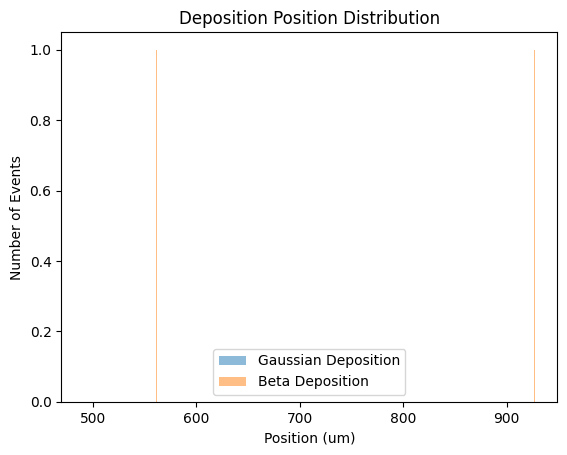

In [4]:
timestep = 0.001e-9
time = np.arange(0, 150e-9, timestep)
ns_time = time * 1e9
xn=0.05
num_pairs = 5
x_inits_alpha = generate_gauss_deposition(xn, 0.001, PAIR_CREATION_E*num_pairs)
x_inits_beta = generate_beta_deposition(PAIR_CREATION_E*num_pairs)
x_inits_constant = np.full(num_pairs, xn)
x_inits_alpha_um = x_inits_alpha * 1e4


plt.hist(x_inits_alpha_um, bins=50, alpha=0.5, label='Gaussian Deposition')
plt.hist(x_inits_beta*1e4, bins=500, alpha=0.5, label='Beta Deposition')
plt.xlabel('Position (um)')
plt.ylabel('Number of Events')
plt.title('Deposition Position Distribution')
plt.legend()

In [5]:
electron_array, hole_array = generate_arrays(timestep, xv, xg)

In [6]:
current_nodiff, _ = generate_current(time, timestep, xn, electron_array, hole_array, 'electron')
current_diff, _, _ = generate_current_w_diffusion(time, timestep, xn, electron_array, hole_array, 'electron')

brute len: -135.0806299594733


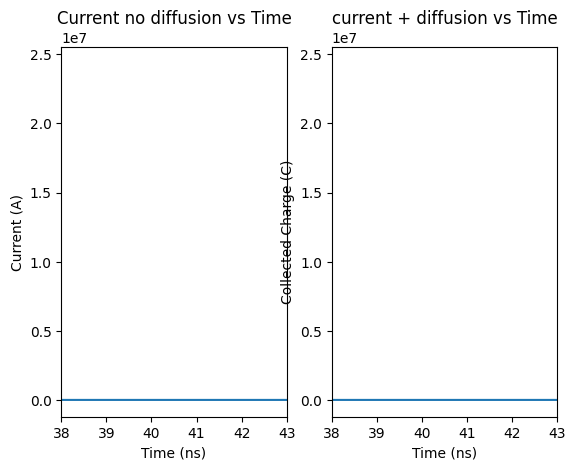

In [7]:
current_nodiff, _ = generate_current(time, timestep, xn, electron_array, hole_array, 'electron')
current_diff, _, brute_len = generate_current_w_diffusion(time, timestep, xn, electron_array, hole_array, 'electron')

fig, ax = plt.subplots(1,2, sharex=True)
ax[0].plot(ns_time, current_nodiff)
ax[0].set_title('Current no diffusion vs Time')
ax[0].set_xlabel('Time (ns)')
ax[0].set_ylabel('Current (A)')
ax[1].plot(ns_time, current_diff)
ax[1].set_title('current + diffusion vs Time')
ax[1].set_xlabel('Time (ns)')
ax[1].set_ylabel('Collected Charge (C)')
plt.xlim(38,43)
print(f'brute len: {brute_len}')

In [8]:
esig = calc_sigma(xn, xv-xn, 'electron')
hsig = calc_sigma(xn, xn-xg, 'hole')

In [9]:
current_diffusion = simulate_event(x_inits_constant, time, timestep, electron_array, hole_array, diff=True)

In [10]:
current_ideal = simulate_event(x_inits_constant, time, timestep, electron_array, hole_array)

In [11]:
current_ideal_blur_e = gauss_blur(current_ideal, esig, timestep) # sigma for electron drift
current_ideal_blur_h = gauss_blur(current_ideal, hsig, timestep) # sigma for hole drift

In [12]:
current_diffusion_by_blur = simulate_event(x_inits_constant, time, timestep, electron_array, hole_array, diff=True, convolve=True)

(15.0, 65.0)

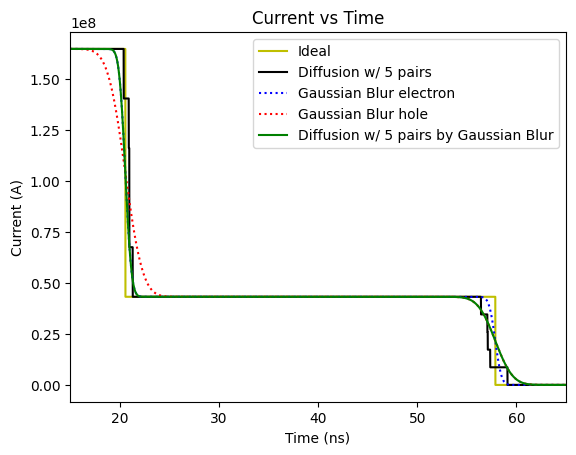

In [13]:
plt.plot(ns_time, current_ideal, 'y', label='Ideal')
plt.plot(ns_time, current_diffusion, color='k',label=f'Diffusion w/ {num_pairs} pairs')
plt.plot(ns_time, current_ideal_blur_e, color='b', linestyle=':', label='Gaussian Blur electron')
plt.plot(ns_time, current_ideal_blur_h, color='r', linestyle=':', label='Gaussian Blur hole')
plt.plot(ns_time, current_diffusion_by_blur, color='g', label=f'Diffusion w/ {num_pairs} pairs by Gaussian Blur')
plt.xlabel('Time (ns)')
plt.ylabel('Current (A)')
plt.title('Current vs Time')
plt.legend()
plt.xlim(15,65)

In [14]:
current_diffusion_a = simulate_event(x_inits_alpha, time, timestep, electron_array, hole_array, diff=True)
current_diffusion_b = simulate_event(x_inits_beta, time, timestep, electron_array, hole_array, diff=True)

In [15]:
current_ideal_a = simulate_event(x_inits_alpha, time, timestep, electron_array, hole_array)
current_ideal_b = simulate_event(x_inits_beta, time, timestep, electron_array, hole_array)

current_ideal_blur_e_a = gauss_blur(current_ideal_a, esig, timestep) # sigma for electron drift
current_ideal_blur_e_b = gauss_blur(current_ideal_b, esig, timestep) # sigma for electron


In [16]:
current_ideal_blur_h_a = gauss_blur(current_ideal_a, hsig, timestep) # sigma for hole drift
current_ideal_blur_h_b = gauss_blur(current_ideal_b, hsig, timestep) # sigma for hole drift

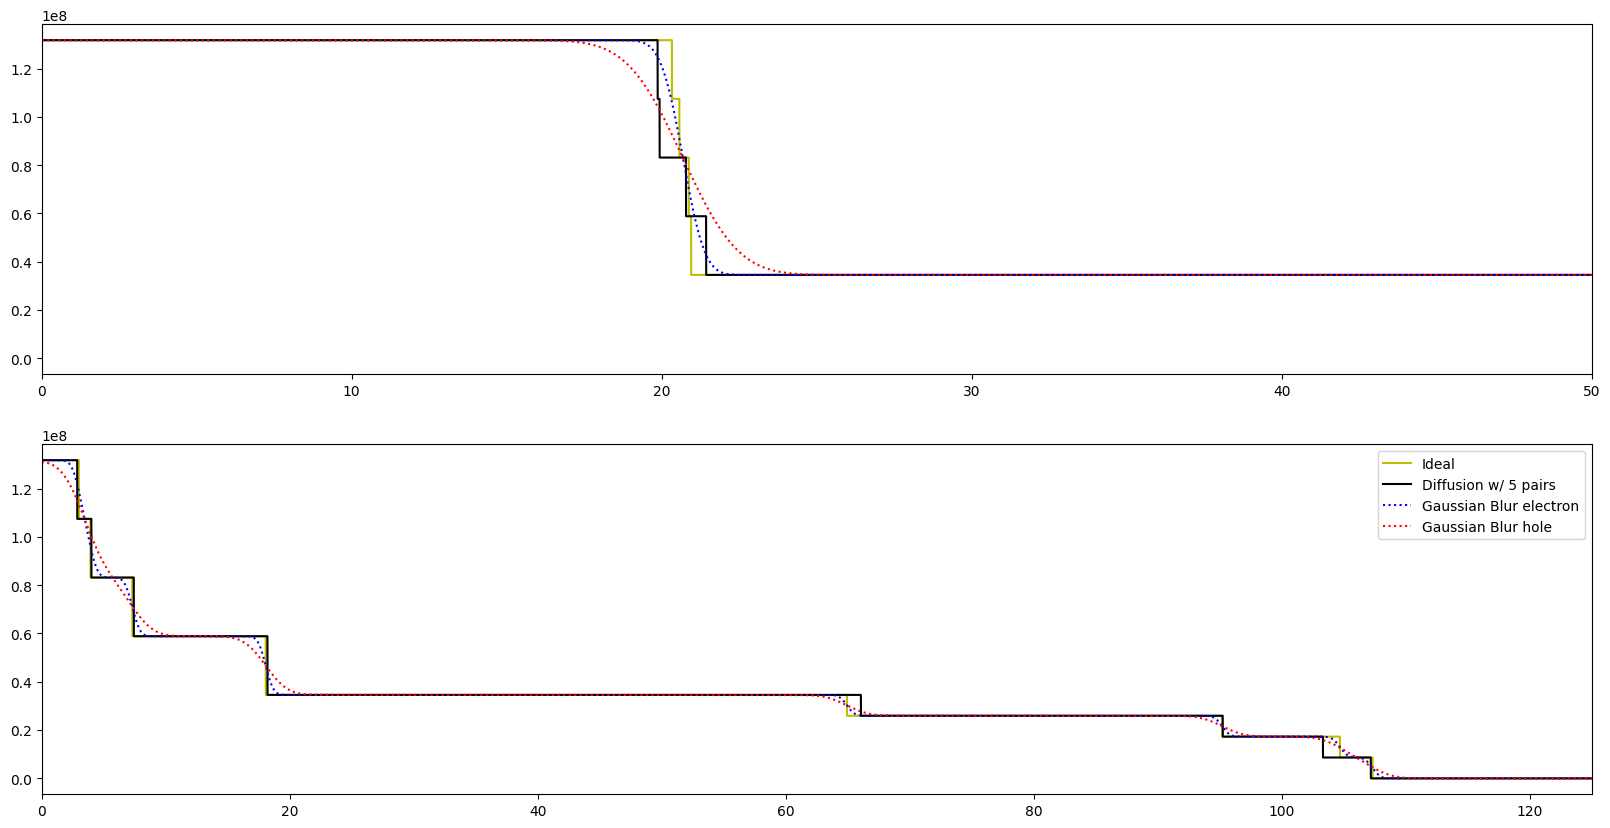

In [17]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(ns_time, current_ideal_a, 'y', label='Ideal')
ax[0].plot(ns_time, current_diffusion_a, color='k',label=f'Diffusion w/ {num_pairs} pairs')
ax[0].plot(ns_time, current_ideal_blur_e_a, color='b', linestyle=':', label='Gaussian Blur electron')
ax[0].plot(ns_time, current_ideal_blur_h_a, color='r', linestyle=':', label='Gaussian Blur hole')
ax[0].set_xlim(0,50)

ax[1].plot(ns_time, current_ideal_b, 'y', label='Ideal')
ax[1].plot(ns_time, current_diffusion_b, color='k',label=f'Diffusion w/ {num_pairs} pairs')
ax[1].plot(ns_time, current_ideal_blur_e_b, color='b', linestyle=':', label='Gaussian Blur electron')
ax[1].plot(ns_time, current_ideal_blur_h_b, color='r', linestyle=':', label='Gaussian Blur hole')
ax[1].set_xlim(0,125)

plt.legend()